# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [2]:
# calcuilate simple error
def error(actual, predicted):
    return actual - predicted

# calculate Mean Absolute Error - MAE
def mae(actual, predicted):
    return np.mean(np.abs(error(actual, predicted)))

# calculate Weighted Absolute Percentage Error - WAPE
def wape_error(actual, predicted):
    return mae(actual, predicted)/np.mean(actual)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [3]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

test_data  = pd.read_csv('data/transformed/DADO_TREINO_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
train_data = pd.read_csv('data/transformed/DADO_TESTE_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)

data = pd.concat([train_data, test_data], axis=0)

data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2014-12-27,404.0,2014-12-27,2014,12,27,0,5
2014-12-28,442.0,2014-12-28,2014,12,28,0,6
2014-12-29,469.0,2014-12-29,2014,12,29,0,0
2014-12-30,481.0,2014-12-30,2014,12,30,0,1
2014-12-31,481.0,2014-12-31,2014,12,31,0,2


# 2. Exploração de dados analíticos

## 2.1 Dados no tempo / Gráfico geral

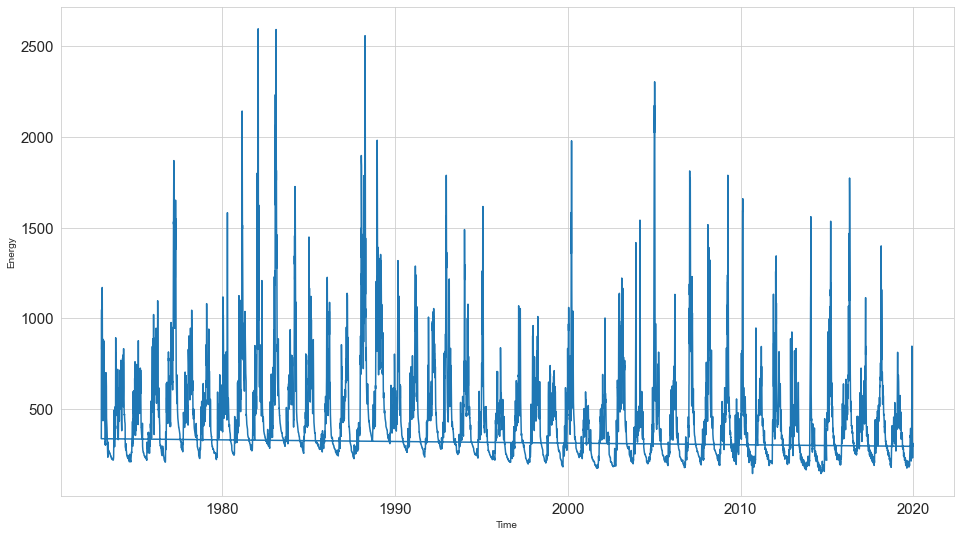

In [4]:
plt.rcParams["figure.figsize"] = [16,9] # dimenção do gráfico
plt.ylabel('Flow') #y
plt.xlabel('Time') #x
plt.plot(data['value']) # impressão dos dados

## 2.2 Informações estatisticas gerais dos dados

In [5]:
describe = data['value'].describe() # descrição dos dados estatisticos
mode = data['value'].mode() #moda
variant = data['value'].var() #variancia
print(f"Variant: {variant}")
print(f"Mode: {mode}")
for key in describe.keys():
    print(f"{key}: {describe[key]}") #outros dados

Variant: 73595.48068882737
Mode: 0    213.0
1    249.0
dtype: float64
count: 17156.0
mean: 453.6590114245745
std: 271.2848699961488
min: 145.0
25%: 273.0
50%: 374.0
75%: 541.0
max: 2595.0


## 2.3 Curva normal do gráfico

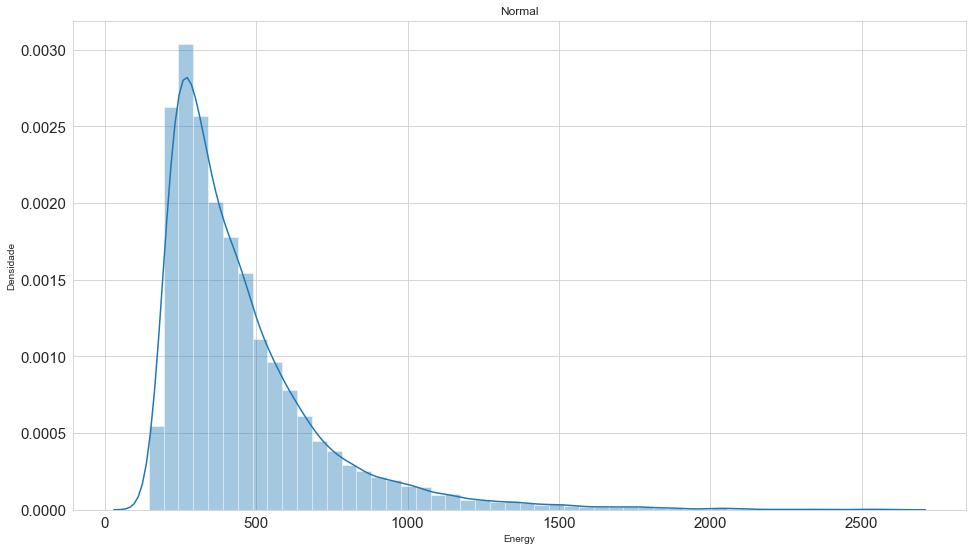

In [6]:
ax = sns.distplot(data['value'], kde=True) # criando a normal
ax.set(xlabel= 'Flow', ylabel='Densidade', title='Normal')
plt.show()

## 2.4 Line

Permite ver dados dos meses ao decorrer do tempo

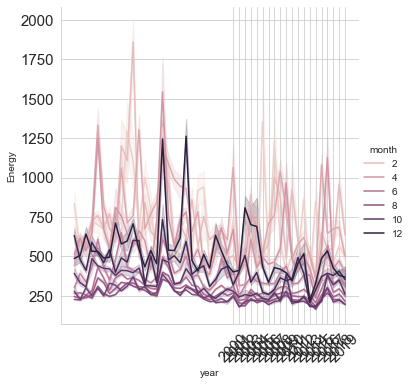

In [7]:
# amostragem de dados por mês em forma de linha do ano de 2000 a 2021
sns.relplot(data=data, x="year", y="value", hue="month", kind='line')
plt.ylabel('Flow')
plt.xticks(np.arange(2000, 2020, 1), rotation=45)
plt.show()
# data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5 Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

Text(0, 0.5, 'Energy')

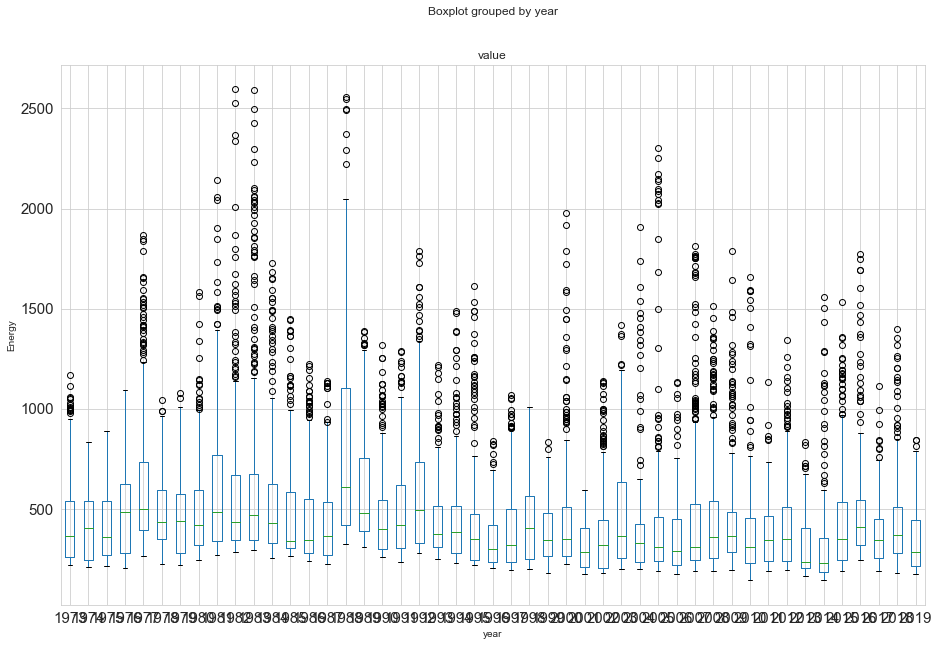

In [8]:
data.boxplot(figsize=(15,10), by='year', column=['value']) # por ano
plt.ylabel('Flow')

# 3. Transformata

## 3.1 Transformada Box-Cox

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

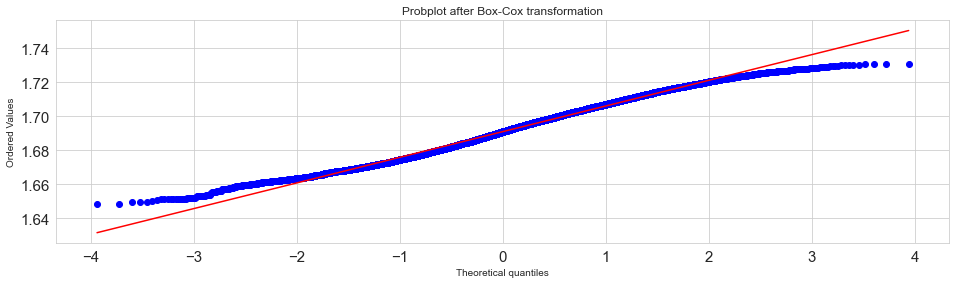

In [9]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2 Transformada Log

A transformação Log diminui o vies dos dados.

None


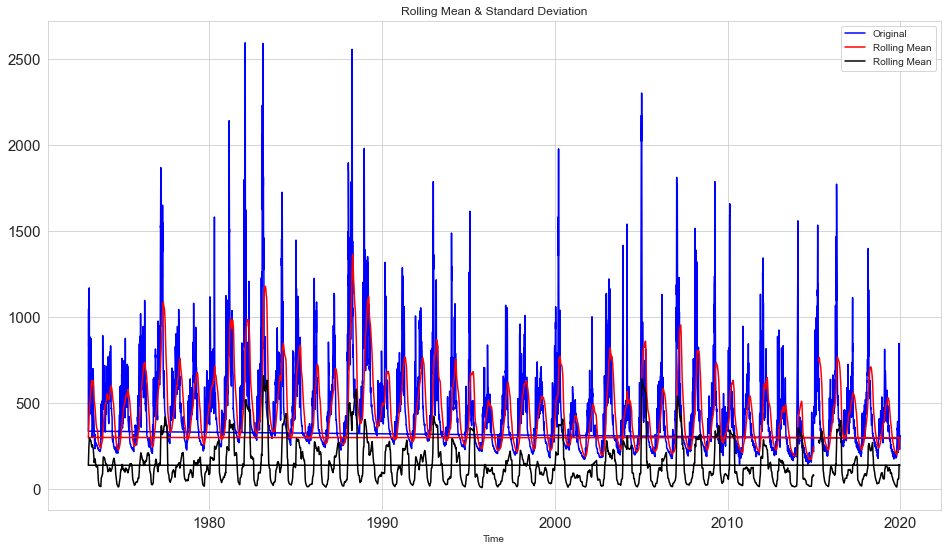

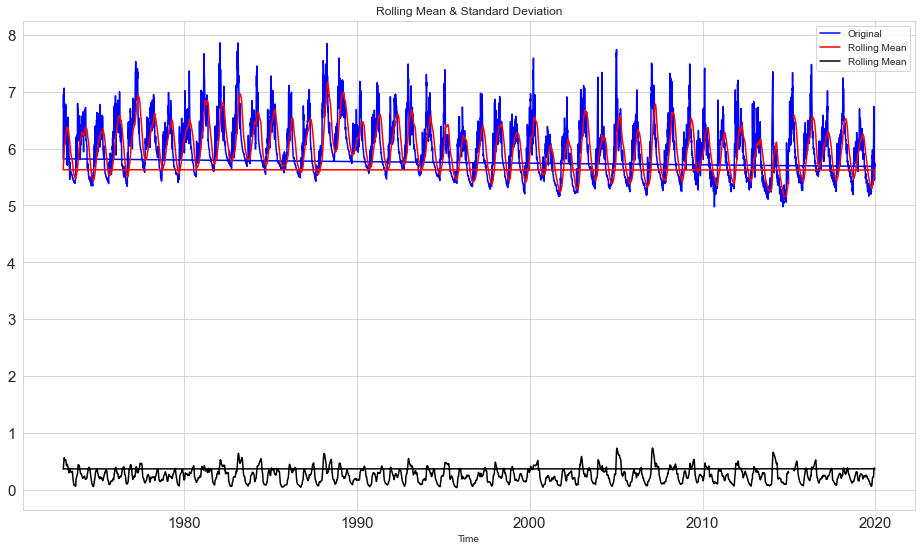

In [10]:
v_log = np.log(data['value']) # criando a transformada ln
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=100):

    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window_size).mean() # media da transformada
    rolling_std  = timeseries.rolling(window_size).std() # desvio

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.show()

test_stationarity(data['value'])

test_stationarity(v_log)
# v_log.to_csv('data/exported/transformed_log.csv')

# 4. Decomposição

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

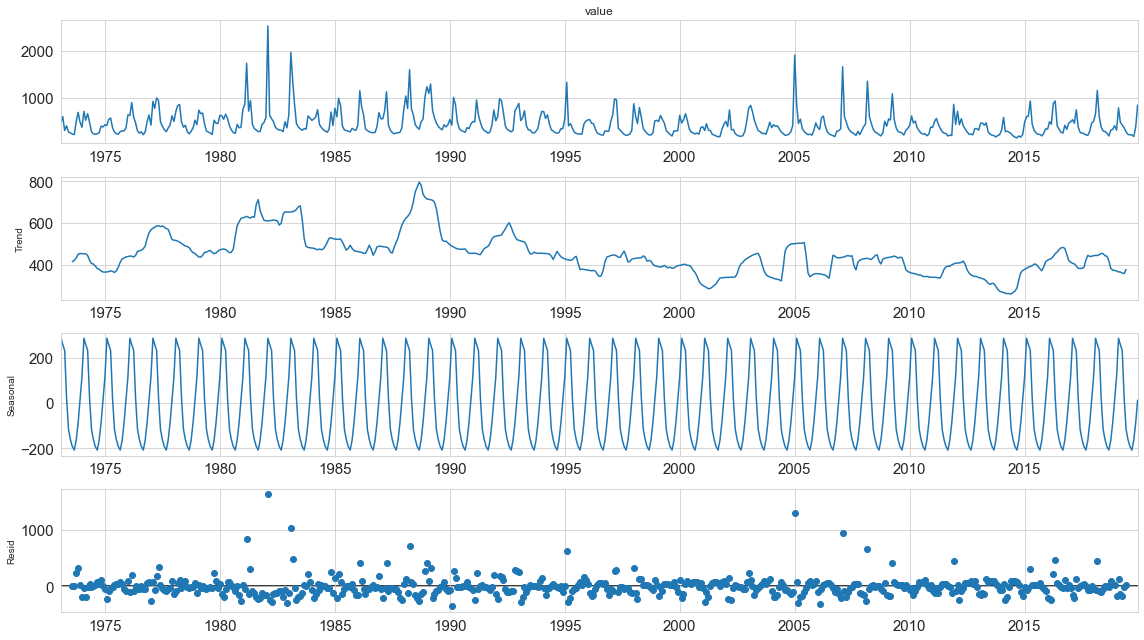

In [11]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Testes de estacionaridades

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1 Teste KPPS

In [12]:
series = data['value']
statistic, p, lags, values = sm.tsa.stattools.kpss(series, 'c')
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: 2.2363150233317968
P Value: 0.01
Lags: 44
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


## 5.2 Teste PP

In [13]:
pp(series)

Test Statistic,-11.780
P-value,0.000
Lags,44


## 5.3 Teste de Dickey Fuller

In [14]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(series.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: -9.641239754197368
P Value: 1.518894309270483e-16 ???
Lags: 17
1%: -3.4310052777423485
5%: -2.8618295937252394
10%: -2.566924145602738


# 6. Persistência

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [15]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

test.head()

,value
index,
2019-01-01,350.0
2019-01-02,385.0
2019-01-03,419.0
2019-01-04,445.0
2019-01-05,460.0


#### Concatenate train and test series to plotting

In [16]:
train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)
series

index
1973-01-01    337.0
1973-01-02    361.0
1973-01-03    476.0
1973-01-04    765.0
1973-01-05    999.0
              ...  
2019-12-17    281.0
2019-12-18    299.0
2019-12-19    312.0
2019-12-20    311.0
2019-12-21    295.0
Name: value, Length: 17157, dtype: float64

#### Prepare data

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [17]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 7

# Store multi-step forecasts
forecasts = list()
forecasts_exp = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)

    # Store the multi-step forecast
    forecasts.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat[0], obs])

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

Ultimos 10 valores:
Predito=477.0, Esperado=426.0
Predito=426.0, Esperado=379.0
Predito=379.0, Esperado=333.0
Predito=333.0, Esperado=299.0
Predito=299.0, Esperado=273.0
Predito=273.0, Esperado=256.0
Predito=256.0, Esperado=243.0
Predito=243.0, Esperado=235.0
Predito=235.0, Esperado=231.0
Predito=231.0, Esperado=239.0


#### Evaluate the forecasts

In [18]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps,sum_mape=None):
    sum_rmse = 0
    sum_mape = 0
    sum_wape = 0
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        wape = sqrt(wape_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        sum_wape += wape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape} | WAPE: {wape}") #erros entre a predição e teste

    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")
    print(f"Média do WAPE: {sum_wape/n_steps}")

evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 22.562552335857514 | MAPE: 3.6607575898719595 | WAPE: 0.19665784312110557
t+2 RMSE: 42.509092234910206 | MAPE: 5.044501105561526 | WAPE: 0.27110090523661673
t+3 RMSE: 60.23770963351045 | MAPE: 5.967677983584513 | WAPE: 0.3208522564598018
t+4 RMSE: 75.36579373515224 | MAPE: 6.635624961120229 | WAPE: 0.35694186275630835
t+5 RMSE: 88.18595226934066 | MAPE: 7.158860500639873 | WAPE: 0.3853001106913996
t+6 RMSE: 98.7660400088299 | MAPE: 7.5710578458656705 | WAPE: 0.4077373677696215
t+7 RMSE: 107.37491556614457 | MAPE: 7.9032473105411505 | WAPE: 0.4259425006859761
Média do RMSE: 70.71457939767794
Média do MAPE: 6.2773896138835585
Média do WAPE: 0.33779040667440424


## 6.1 Predições com multiplos passos

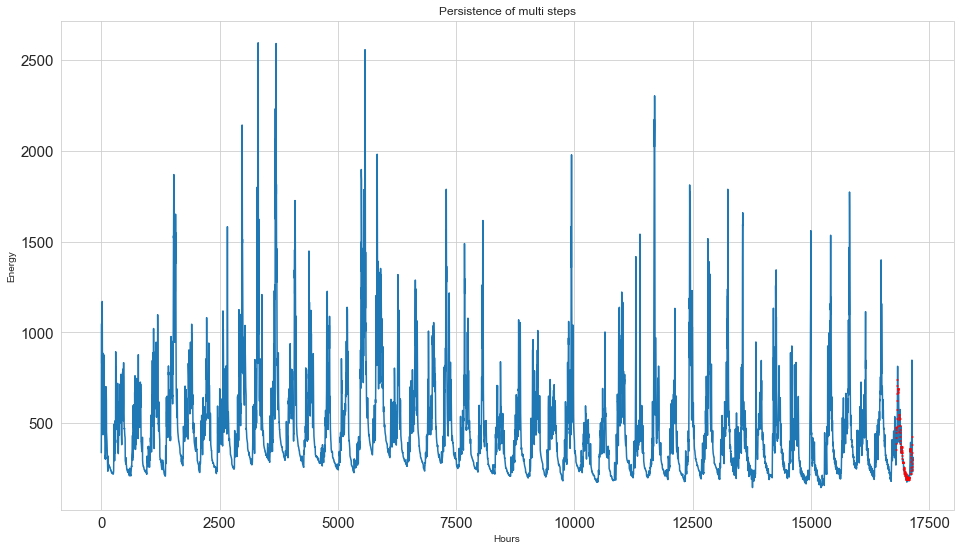

In [19]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    x_points = []
    y_points = []
    plt.plot(series)

    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1

        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1

        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        # x_points.append(xaxis)
        # xaxis = np.array(xaxis)

        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        # y_points.append(yaxis)
        # yaxis = np.array(yaxis)
        plt.plot(xaxis, yaxis, color='red')

        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    plt.ylabel('Flow')
    plt.xlabel('Time')
    plt.title('Persistence of multi steps')
    plt.show()


plot_forecasts(series, forecasts, test)

## 6.2 Persistência com um passo

In [20]:
pred_exp = list()
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = train[-1]
    # Store forecast in list of predictions
    predictions.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    pred_exp.append([yhat, obs])
    # print(f">Predicted={yhat}, Expected={obs}")

#### Performance

In [21]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = sqrt(mean_absolute_error(test, predictions))
wape = sqrt(wape_error(test, predictions))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))
print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

RMSE: 23.237 | MAPE:   4
Ultimos 10 valores:
Predito=256.0, Esperado=243.0
Predito=243.0, Esperado=235.0
Predito=235.0, Esperado=231.0
Predito=231.0, Esperado=239.0
Predito=239.0, Esperado=254.0
Predito=254.0, Esperado=281.0
Predito=281.0, Esperado=299.0
Predito=299.0, Esperado=312.0
Predito=312.0, Esperado=311.0
Predito=311.0, Esperado=295.0


#### Predito vs Esperado

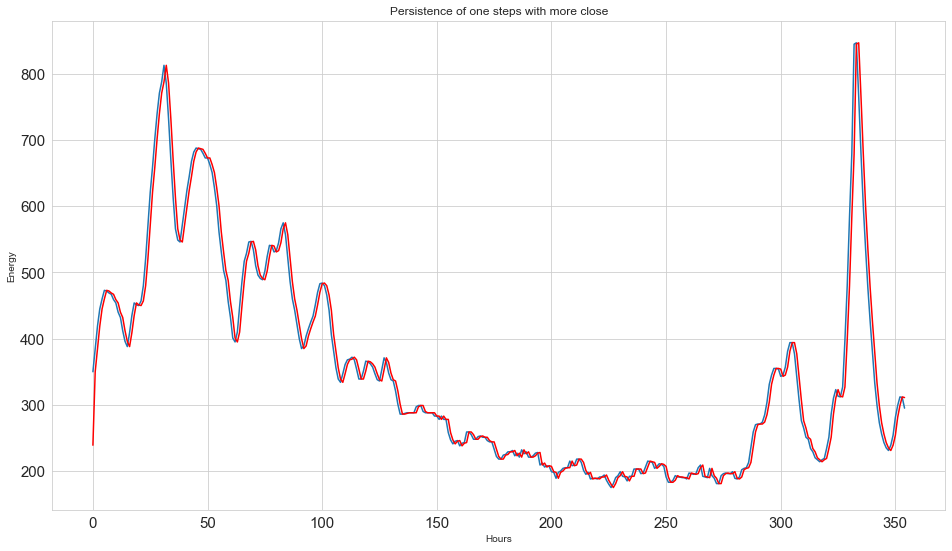

In [22]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.ylabel('Flow')
plt.xlabel('Time')
plt.title('Persistence of one steps with more close')
plt.show()

# 7. Suavização Exponencial


In [23]:
# precisa colocar as datas que o professor pediu para o treino e teste
df = data['2015-01-01':]

split_date = '2019-01-01'
test = df[split_date : ]
train = df[ : split_date]

train_v = train['value']
test_v = test['value']

test_vv = test_v.values
train_vv = [x for x in train_v]

## 7.1 Suavização Exponêncial Simples

t+1 RMSE: 34.01192242657626 | MAPE: 4.495605148919848 | WAPE: 0.24150629764633955
t+2 RMSE: 52.27878340130959 | MAPE: 5.547313229838629 | WAPE: 0.29812296732025567
t+3 RMSE: 68.35114780064282 | MAPE: 6.3476382035250785 | WAPE: 0.3412808208475315
t+4 RMSE: 82.0202284593808 | MAPE: 6.918781717216442 | WAPE: 0.3721733594977929
t+5 RMSE: 93.48756513353989 | MAPE: 7.374561292150269 | WAPE: 0.3969094357840941
t+6 RMSE: 102.92190685431352 | MAPE: 7.74126711414731 | WAPE: 0.4169039440172256
t+7 RMSE: 110.55622790072466 | MAPE: 8.015729820227943 | WAPE: 0.43200470266155194
Média RMSE: 77.66111171092679
Média MAPE: 6.634413789432218
Média MAPE: 0.3569859325392559
Ultimos 10 valores:
Predito=518.7055251572616, Esperado=426.0
Predito=463.08221006290466, Esperado=379.0
Predito=412.63288402516184, Esperado=333.0
Predito=364.85315361006474, Esperado=299.0
Predito=325.3412614440259, Esperado=273.0
Predito=293.9365045776103, Esperado=256.0
Predito=271.17460183104413, Esperado=243.0
Predito=254.26984073

Text(0.5, 1.0, 'Holt Method with multi steps')

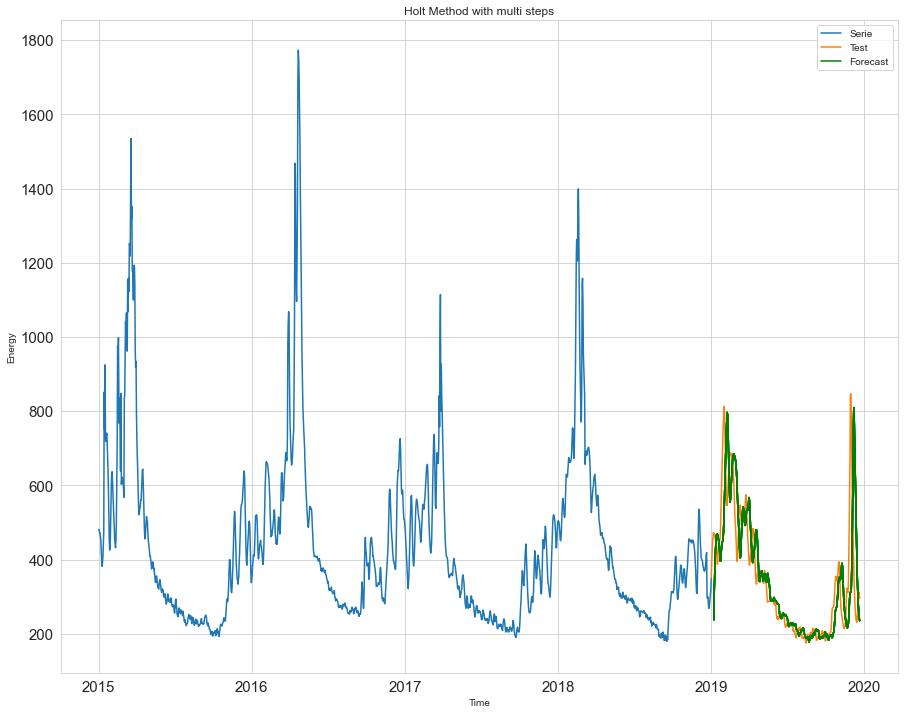

In [25]:
def simple_exp_smoothing(train, alpha, n_steps=1):
    estimated = SimpleExpSmoothing(train, initialization_method="estimated")
    _fit = estimated.fit(smoothing_level=alpha, optimized=False)
    return _fit.forecast(n_steps)

pred = list()
pred_exp = list()
n_steps = 7
n_forecasts = len(test_vv) - n_steps + 1

for i in range(n_forecasts):
    forecast = simple_exp_smoothing(train_vv, 0.6, n_steps)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    sum_wape = 0

    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        wape = sqrt(wape_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        sum_wape += wape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape} | WAPE: {wape}")
    print(f"Média RMSE: {sum_rmse/n_steps}")
    print(f"Média MAPE: {sum_mape/n_steps}")
    print(f"Média WAPE: {sum_wape/n_steps}")

evaluate_forecasts(test_vv, pred, n_steps)

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index[n_steps-1:], pred, color='green')
plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Flow')
plt.xlabel('Time')
plt.title('Simple Exponencial Smoothing')

## 7.2 Suavização exponencial Holt-Winter

RMSE: 20.812 | MAPE:   3 | WAPE:   1
Ultimos 10 valores:
Predito=234.81691314781324, Esperado=243.0
Predito=229.241189634579, Esperado=235.0
Predito=225.28177323445033, Esperado=231.0
Predito=225.13027226311823, Esperado=239.0
Predito=237.38258454450138, Esperado=254.0
Predito=264.526780181836, Esperado=281.0
Predito=304.96800309941034, Esperado=299.0
Predito=324.38996289308943, Esperado=312.0
Predito=326.1548155281882, Esperado=311.0
Predito=319.60134589575443, Esperado=295.0


Text(0.5, 1.0, 'Holt Winter')

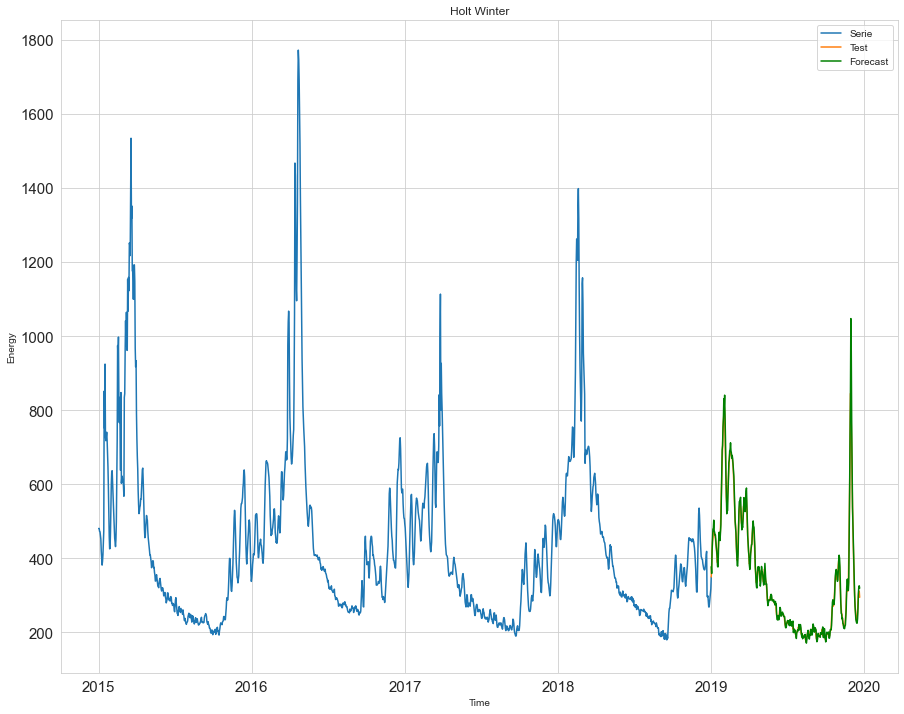

In [27]:
test_vv = test_v.values
train_vv = [x for x in train_v]

def holt_winter_method(train, n_steps=0):
    estimated = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated")
    _fit = estimated.fit(optimized=True)
    return _fit.forecast(n_steps)


pred = list()
pred_exp = list()
for i in range(len(test_vv)):
    # Predict
    forecast = holt_winter_method(train_vv)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

rmse = sqrt(mean_squared_error(test_vv, pred))
mape = sqrt(mean_absolute_error(test_vv, pred))
wape = sqrt(wape_error(test_vv, pred))
print('RMSE: %.3f | MAPE: %3.f | WAPE: %3.f' % (rmse, mape, wape))

print("Ultimos 10 valores:")
for item in pred_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index, pred, color='green')

plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Flow')
plt.xlabel('Time')
plt.title('Holt Winter')